In [6]:
import torch
import torch.nn as nn


class SimpleUNetV2(nn.Module):
    def __init__(self, dropout_rate: float = 0.3) -> None:
        super().__init__()
        self.dropout_rate = dropout_rate

        # Encoder
        self.enc1 = self.conv_block(4, 32)
        self.enc2 = self.conv_block(32, 64)

        # Bottleneck
        self.bottleneck = self.conv_block(64, 128)
        self.dropout_bottleneck = nn.Dropout2d(p=self.dropout_rate)

        # Decoder
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        self.dropout_dec1 = nn.Dropout2d(p=self.dropout_rate)

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(64, 32)

        self.final = nn.Conv2d(32, 1, kernel_size=1)
        self.pool = nn.MaxPool2d(2)

    def conv_block(self, in_ch: int, out_ch: int) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: nn.Sequential) -> nn.Conv2d:
        # Encode
        x1 = self.enc1(x)  # (B, 32, H, W)
        x2 = self.enc2(self.pool(x1))  # (B, 64, H/2, W/2)

        # Bottleneck + dropout
        x3 = self.bottleneck(self.pool(x2))
        x3 = self.dropout_bottleneck(x3)  # (B, 128, H/4, W/4)

        # Decode
        x4 = self.up1(x3)
        x4 = self.dec1(torch.cat([x4, x2], dim=1))
        x4 = self.dropout_dec1(x4)

        x5 = self.up2(x4)
        x5 = self.dec2(torch.cat([x5, x1], dim=1))

        return self.final(x5)  # (B, 1, H, W)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14345905..1.2463324].


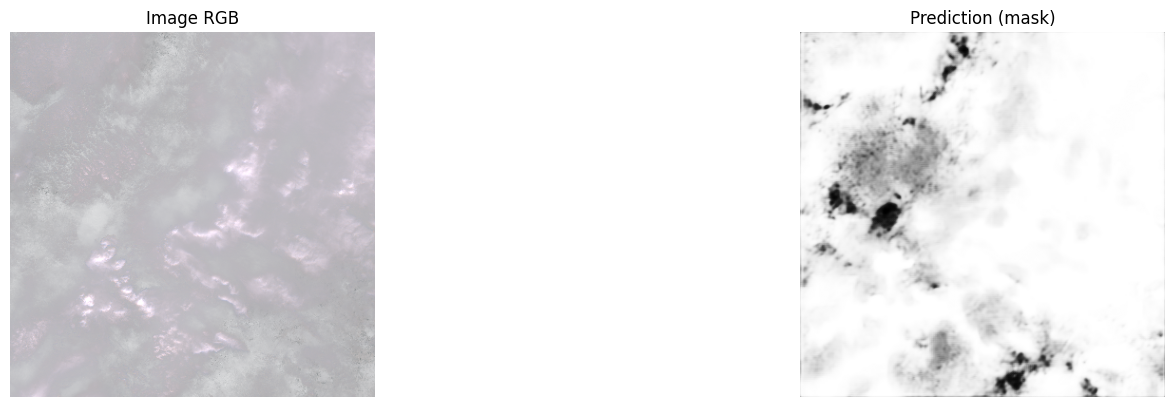

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.101289].


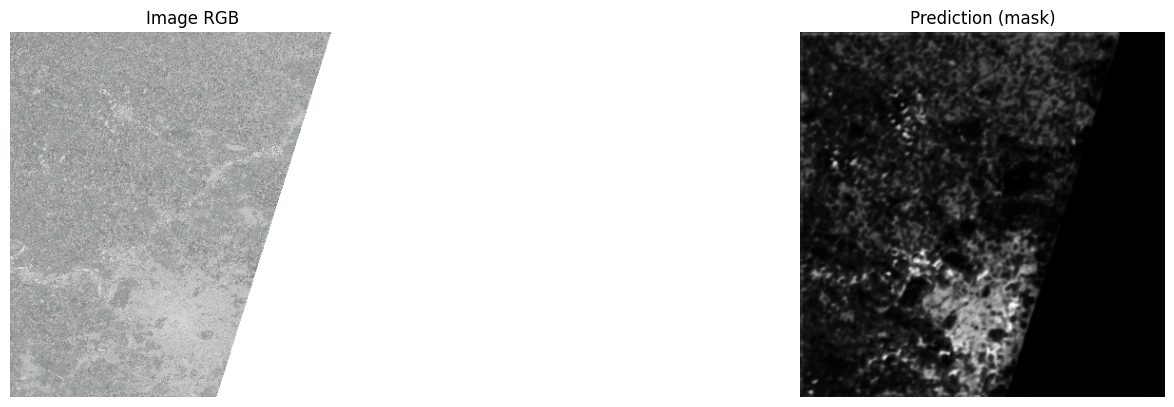

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12844811..1.5276173].


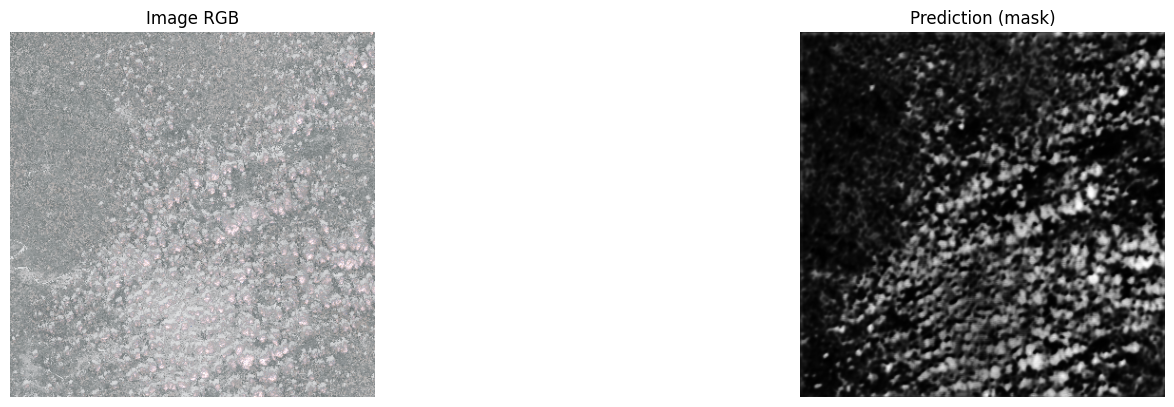

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12605903..1.4956579].


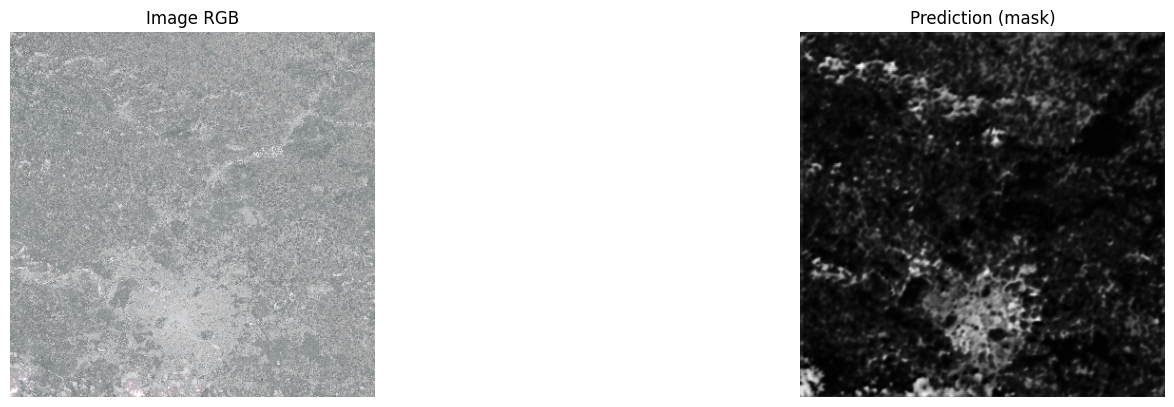

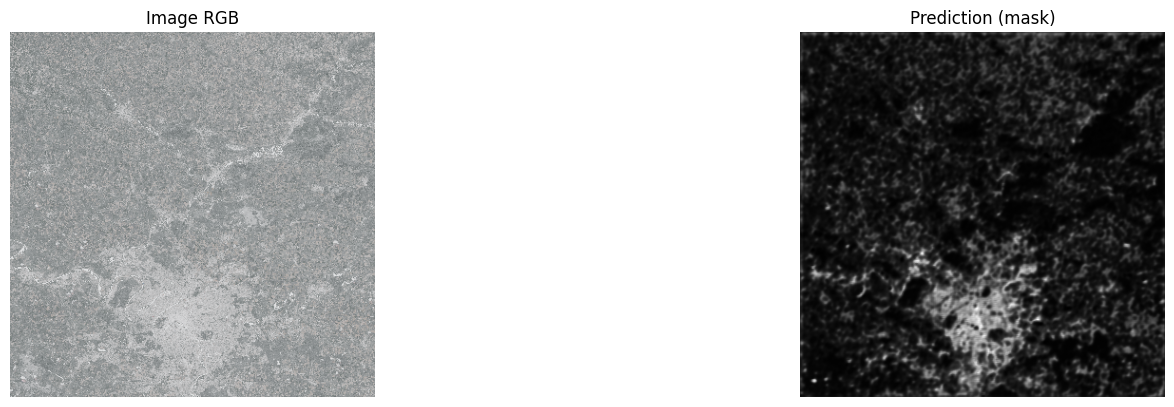

KeyboardInterrupt: 

In [6]:
import torch
import torch.nn.functional as F
import numpy as np
import rasterio
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import transforms


def get_images_paths(root: Path):
    rgb_sets = []
    for date_dir in root.iterdir():
        # if date_dir.name != "2025-05-16":
        #     continue
        for tile_dir in date_dir.iterdir():
            red = tile_dir / "red" / "B04.jp2"
            green = tile_dir / "green" / "B03.jp2"
            blue = tile_dir / "blue" / "B02.jp2"
            nir = tile_dir / "nir" / "B08.jp2"
            if red.exists() and green.exists() and blue.exists() and nir.exists():
                rgb_sets.append((red, green, blue, nir))
    return rgb_sets


def load_model(model_path: Path, device: torch.device):
    model = SimpleUNetV2()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model


def read_rgb_image(red_path: Path, green_path: Path, blue_path: Path, nir_path: Path) -> np.ndarray:
    with rasterio.open(red_path) as r:
        red = r.read(1).astype(np.float32)
    with rasterio.open(green_path) as g:
        green = g.read(1).astype(np.float32)
    with rasterio.open(blue_path) as b:
        blue = b.read(1).astype(np.float32)
    with rasterio.open(nir_path) as n:
        nir = n.read(1).astype(np.float32)

    stacked = np.stack([red, green, blue, nir], axis=0)  # [4, H, W]
    return stacked / 10000.0  # Normalisation Sentinel-2 standard


import torch.nn.functional as F


def preprocess(image: np.ndarray, size: int = 384) -> torch.Tensor:
    tensor = torch.from_numpy(image)  # [4, H, W]
    tensor = tensor.to("cpu").unsqueeze(0)  # (1, 4, H, W)
    tensor = F.interpolate(tensor, size=(size, size), mode="bilinear", align_corners=False)
    return tensor.squeeze(0)  # [4, H, W]
    # return tensor


def predict_mask(model, image_tensor: torch.Tensor, device: torch.device) -> np.ndarray:
    with torch.no_grad():
        input_tensor = image_tensor.unsqueeze(0).to(device)  # [1, 4, H, W]
        prediction = model(input_tensor)
        prob_map = torch.sigmoid(prediction).squeeze().cpu().numpy()  # [1, H, W] -> [H, W]
        return prob_map


def display_prediction(image_tensor, mask):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image_tensor.permute(1, 2, 0).numpy())  # [H, W, C]
    axs[0].set_title("Image RGB")
    axs[2].imshow(mask, cmap="gray")
    axs[2].set_title("Prediction (mask)")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def inference_pipeline(root: Path, model_path: Path, device_str="cuda" if torch.cuda.is_available() else "cpu"):
    device = torch.device(device_str)
    model = load_model(model_path, device)
    triplets = get_images_paths(root)

    for red, green, blue, nir in triplets:
        rgb = read_rgb_image(red, green, blue, nir)
        rgb_tensor = preprocess(rgb)
        mask = predict_mask(model, rgb_tensor, device)
        display_prediction(rgb_tensor, mask)


# Exemple d'appel
inference_pipeline(
    Path(r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data\sentinel2-b"),
    Path(
        r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite\satellite\exploration\models\simple_unet_v2_subset4000_epoch20.pth"
    ),
)


In [ ]:
import numpy as np
import pandas as pd
import rasterio
import torch

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, Subset


class InferenceSegmentationDataset(Dataset):
    def __init__(self, csv_file: Path) -> None:
        self.data = pd.read_csv(csv_file)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> torch.Tensor:
        row = self.data.iloc[idx]

        channels = []
        for band in ["red", "green", "blue", "near_infrared"]:
            with rasterio.open(row[band]) as src:
                img = src.read(1).astype(np.float32) / 65535.0  # 2D image
                channels.append(img)

        image = np.stack(channels, axis=0)  # (4, H, W)

        return torch.tensor(image, dtype=torch.float32)


dataset = InferenceSegmentationDataset(
    Path("dataset.csv"),
)
loader = DataLoader(dataset, batch_size=4, shuffle=True)
for images in loader:
    print(images.shape)  # Should be (batch_size, 4, H, W)
    break  # Just to test the first batch

ValueError: too many values to unpack (expected 2)

In [10]:
for images in loader:
    print(images.shape)  # Should be (batch_size, 4, H, W)
    break  # Just to test the first batch

torch.Size([4, 4, 10980, 10980])


In [7]:
model = SimpleUNetV2()
# load model on cpu
model.load_state_dict(
    torch.load(
        Path(
            r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite\satellite\exploration\models\simple_unet_v2_subset4000_epoch20.pth"
        ),
        map_location=torch.device("cpu"),
    )
)

<All keys matched successfully>

In [13]:
import matplotlib.pyplot as plt
import torch.nn.functional as F


def visualize_predictions(model, dataset, num_samples=1, threshold=0.5):
    model.eval()
    device = next(model.parameters()).device

    for i in range(num_samples):
        image = dataset[i]
        image = image.to(device).unsqueeze(0)  # (1, 4, H, W)

        with torch.no_grad():
            pred = model(image)
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()  # (H, W)

        image_rgb = image.squeeze().cpu()[:3].numpy().transpose(1, 2, 0)  # (H, W, 3)
        pred_mask = (pred > threshold).astype(float)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(image_rgb)
        axs[0].set_title("Image RGB")
        axs[2].imshow(pred_mask, cmap="gray")
        axs[2].set_title("Prediction (mask)")

        for ax in axs:
            ax.axis("off")

        plt.tight_layout()
        plt.show()


visualize_predictions(model, dataset)

KeyboardInterrupt: 

In [7]:
import pandas as pd


df = pd.read_csv("dataset.csv")

sample = df.iloc[-1]


# Charger les images
def load_band(path):
    with rasterio.open(path) as src:
        return src.read(1).astype(np.float32)


red = load_band(sample["red"])
green = load_band(sample["green"])
blue = load_band(sample["blue"])
nir = load_band(sample["nir"])


# Fonction de normalisation pour affichage
def normalize_stretch(img, min_percent=2, max_percent=98):
    min_val = np.percentile(img, min_percent)
    max_val = np.percentile(img, max_percent)
    return np.clip((img - min_val) / (max_val - min_val), 0, 1)


# Normaliser les bandes pour affichage
red_n = normalize_stretch(red)
green_n = normalize_stretch(green)
blue_n = normalize_stretch(blue)
nir_n = normalize_stretch(nir)

---

In [12]:
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import torch
import rasterio
from pathlib import Path


class SentinelTilingDataset(Dataset):
    def __init__(self, csv_file: Path, tile_size: int = 384):
        self.data = pd.read_csv(csv_file)
        self.tile_size = tile_size
        self.tiles_index = []

        for idx, row in self.data.iterrows():
            with rasterio.open(row["red"]) as src:
                height, width = src.height, src.width

            for y in range(0, height, tile_size):
                for x in range(0, width, tile_size):
                    if y + tile_size <= height and x + tile_size <= width:
                        self.tiles_index.append((idx, y, x))

    def __len__(self):
        return len(self.tiles_index)

    def __getitem__(self, i: int) -> tuple[torch.Tensor, tuple[int, int]]:
        row_idx, y, x = self.tiles_index[i]
        row = self.data.iloc[row_idx]

        channels = []
        for band in ["red", "green", "blue", "near_infrared"]:
            with rasterio.open(row[band]) as src:
                img = src.read(1, window=((y, y + self.tile_size), (x, x + self.tile_size)))
                img = img.astype(np.float32) / 65535.0
                channels.append(img)

        image = np.stack(channels, axis=0)  # (4, H, W)
        _, h, w = image.shape

        if h != self.tile_size or w != self.tile_size:
            raise ValueError(f"Tuile de taille incorrecte : {h}x{w} au lieu de {self.tile_size}")

        return torch.tensor(image, dtype=torch.float32), (row_idx, y, x)


In [ ]:
def run_inference(model, dataset, image_shape=(10180, 10180), tile_size=384, device="cpu"):
    model.eval()
    masks_per_image = {}

    # Forcer des dimensions multiples de tile_size
    H_valid = (image_shape[0] // tile_size) * tile_size
    W_valid = (image_shape[1] // tile_size) * tile_size

    with torch.no_grad():
        for image, (image_idx, y, x) in dataset:
            if y + tile_size > H_valid or x + tile_size > W_valid:
                continue  # ⛔️ On saute les tuiles qui déborderaient
            image = image.unsqueeze(0).to(device)
            pred = model(image)
            pred = torch.sigmoid(pred).squeeze().cpu()  # (H, W)

            if image_idx not in masks_per_image:
                masks_per_image[image_idx] = torch.zeros((H_valid, W_valid), dtype=torch.float32)

            masks_per_image[image_idx][y : y + tile_size, x : x + tile_size] = pred

    return masks_per_image


import matplotlib.pyplot as plt


def show_prediction(full_mask: np.ndarray, threshold=0.5):
    binary = (full_mask > threshold).astype(float)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary, cmap="gray")
    plt.title("Masque reconstruit")
    plt.axis("off")
    plt.show()


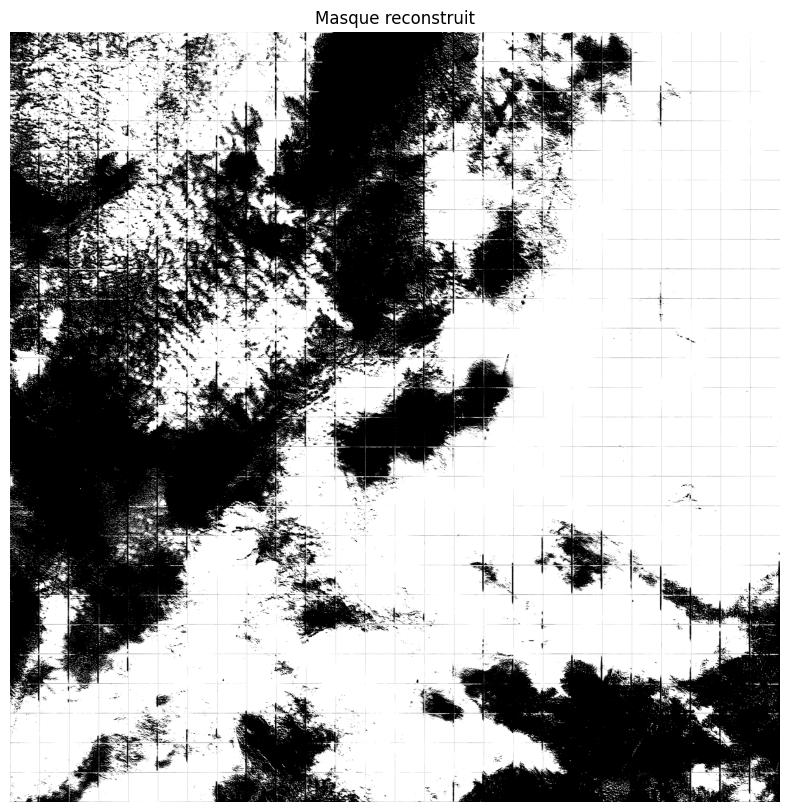

In [18]:
csv_path = Path("dataset.csv")
dataset = SentinelTilingDataset(csv_path)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Assure-toi que model est déjà chargé
masks = run_inference(model, dataset, device=device)

# Affiche le premier masque
show_prediction(masks[0].numpy(), threshold=0.5)


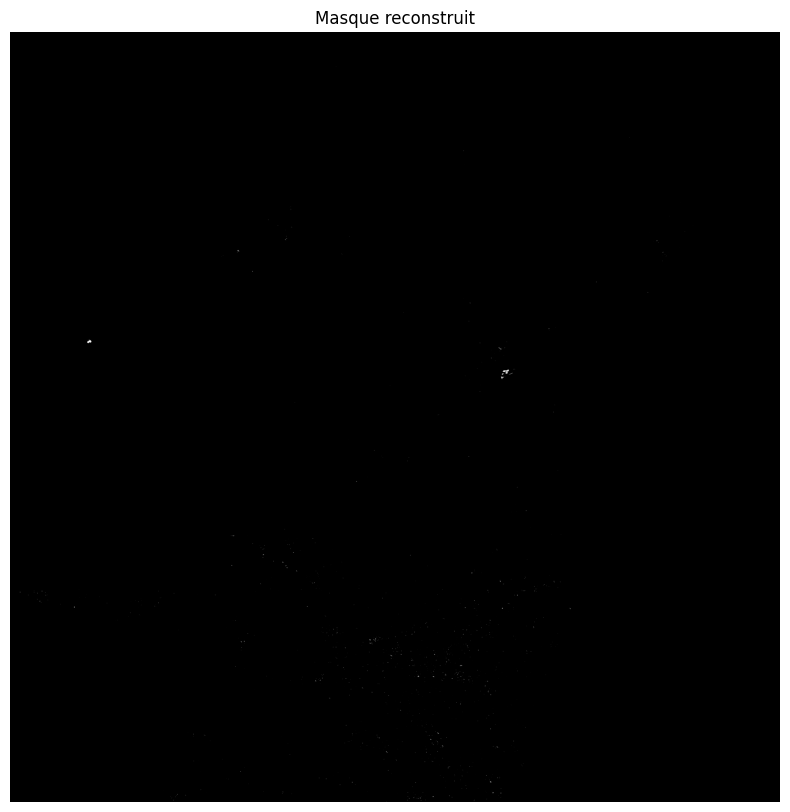

In [19]:
show_prediction(masks[1].numpy(), threshold=0.5)

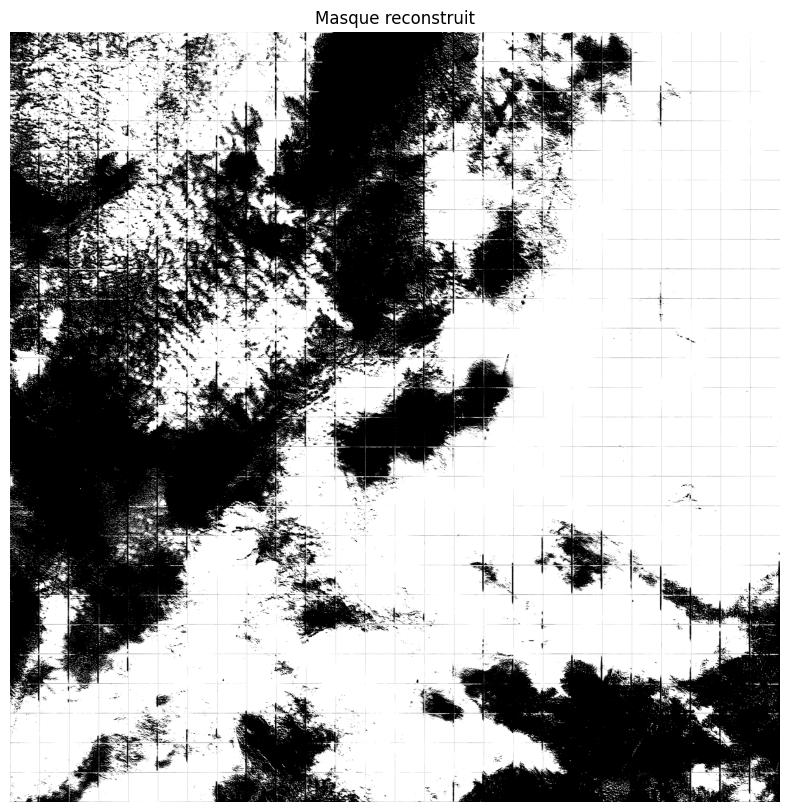

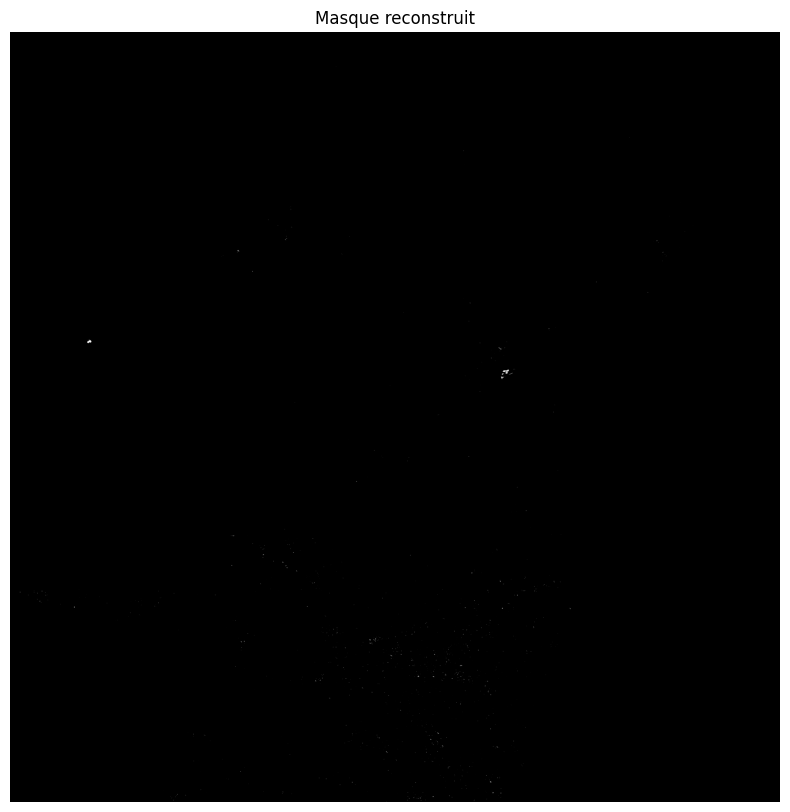

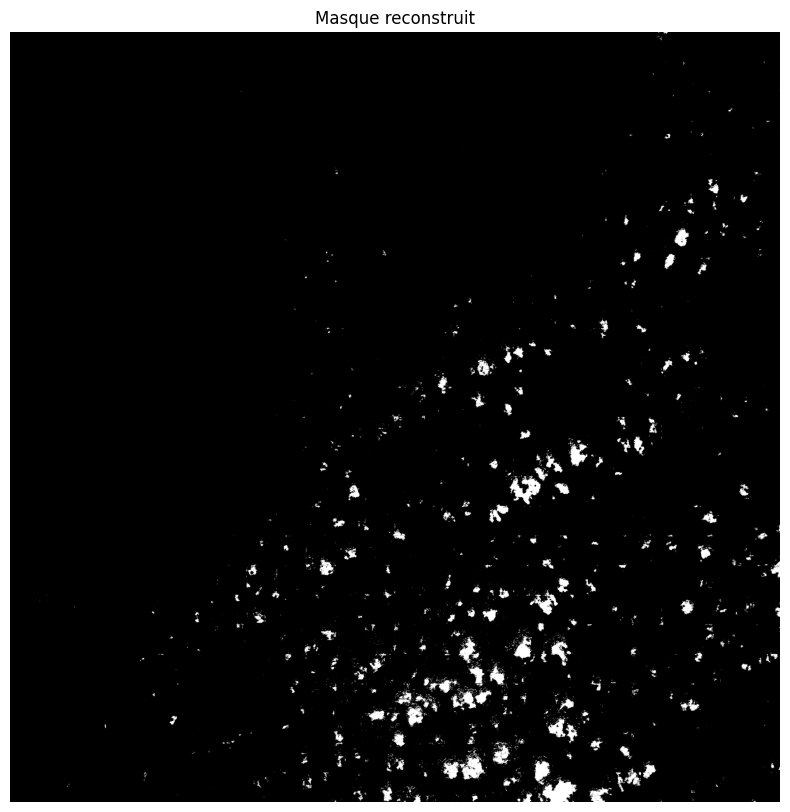

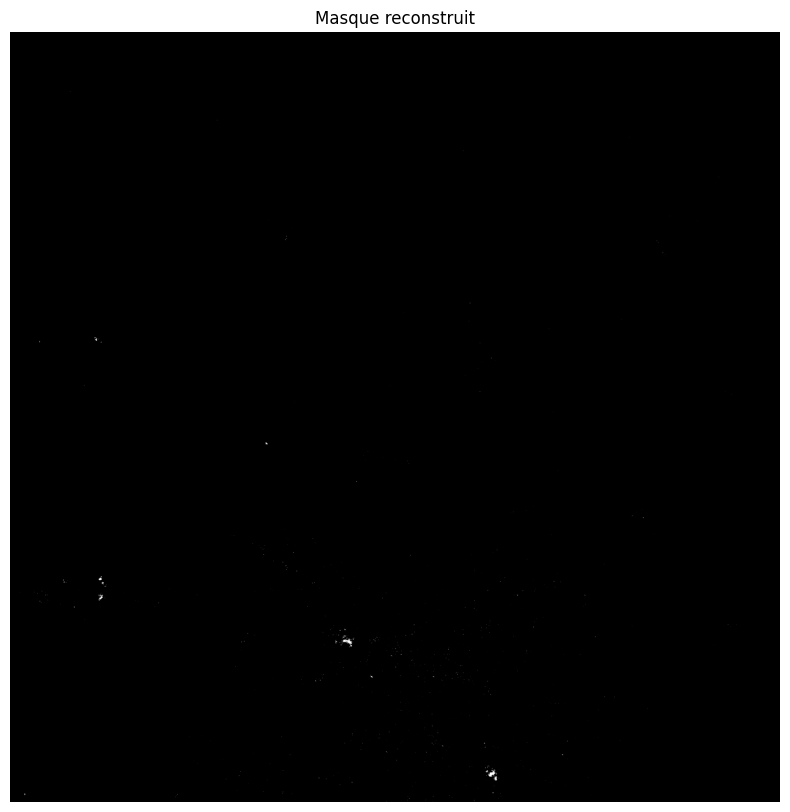

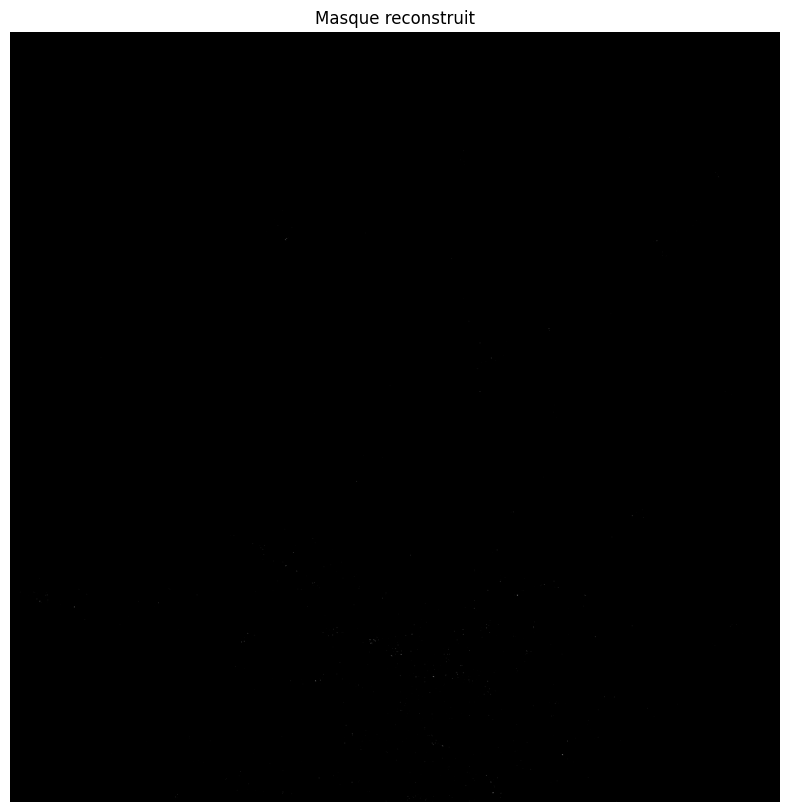

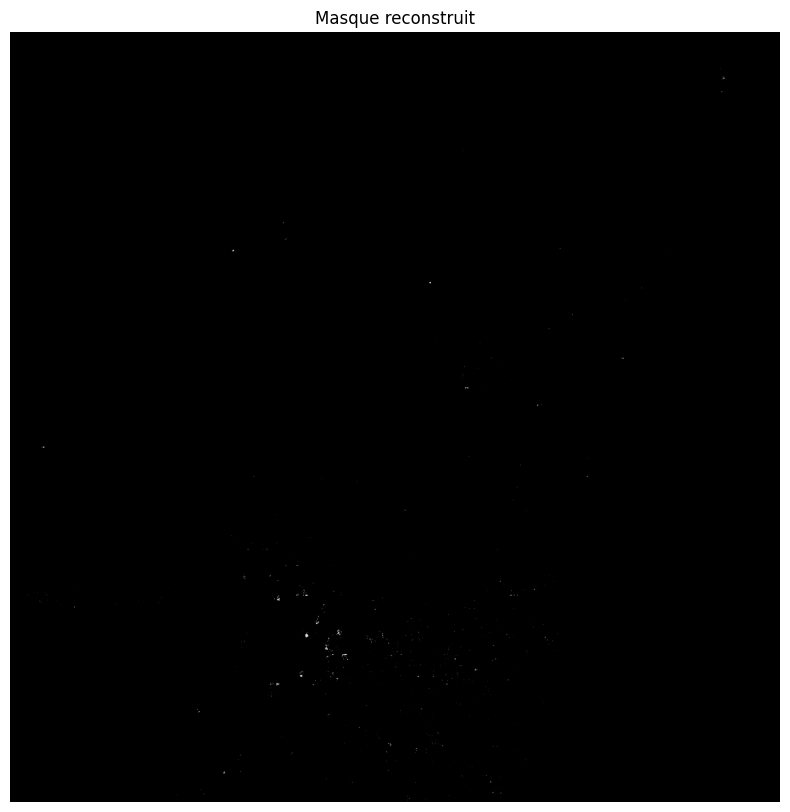

In [20]:
for idx, mask in masks.items():
    show_prediction(mask.numpy(), threshold=0.5)